In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from tqdm import tqdm

## Задание 1.
**Проведите исследование того, как мощность T-test зависит от пропорций выборки.**
1) Для этого сгенерируйте выборку из 1000000 значений из нормального распределения со средний значением 100 и СКО 1000.
2) Далее разделите выборку в пропорции 50 на 50
3) Проведите синтетический AB тест, в котором группе B дайте разные размеры эффект (от 1% до 100% с шагом в 10%)
4) Посчитайте вероятность ошибки 2 рода
5) Повторите операции для выборок с пропорцией: 10 на 90, 20 на 80, 30 на 70, 40 на 60, где меньшее значение - это будет размер контрольной группы, а большее - размер тестовой группы
6) Постройте график, где по оси X будет размер эффекта, по оси Y вероятность ошибки 2 рода, а каждая линия соответсвует одной из пропорции

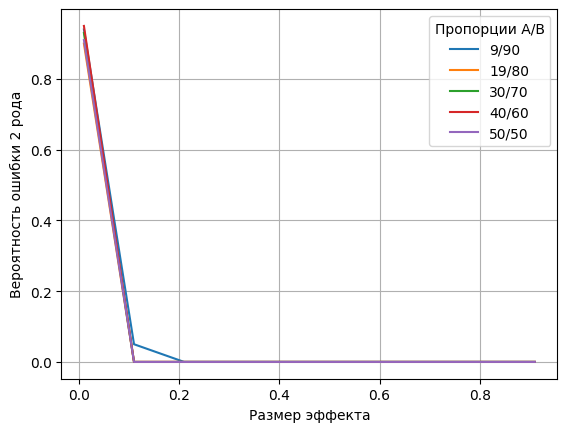

In [6]:
from sklearn.model_selection import train_test_split

samples = np.random.normal(loc=100, scale=1000, size=1000000)
effects = np.arange(0.01, 1.01, 0.1)
type_2_errors_all = []
labels = []
proportions = [0.9, 0.8, 0.7, 0.6, 0.5]
n_exp = 100

for prop in proportions:
  type_2_errors = []

  for effect in effects:
    errors = 0

    for _ in range(n_exp):
      s1, s2 = train_test_split(samples, test_size=prop)
      s2_effect = s2 * (1 + effect)
      _, p_val = ttest_ind(s1, s2_effect, equal_var=False)
      if p_val >= 0.05: errors += 1

    type_2_errors.append(errors / n_exp)

  type_2_errors_all.append(type_2_errors)

  control_share = 1 - prop
  test_share = prop
  labels.append(f"{int(control_share * 100)}/{int(test_share * 100)}")

for errors, label in zip(type_2_errors_all, labels):
  plt.plot(effects, errors, label=label)

plt.xlabel("Размер эффекта")
plt.ylabel("Вероятность ошибки 2 рода")
plt.legend(title="Пропорции A/B")
plt.grid(True)
plt.show()

## Задание 2.
**Подведение результатов эксперимента**
1) Откройте файл с данными `data_with_test_results.csv`
2) Посчитайте посчитайте количество заказов у каждого клиента за период эксперимента
3) Посчитайте насколько значимы изменения среднего количества заказов у клиента в группе B по сравнению с группой А с помощью t-теста и бутстрапа
4) Постройте график с кумулятивным среднийм значеним в группе A и B и посмотрите насколько этот эффект виден

In [9]:
data1 = pd.read_csv('/data_with_test_results-57f50604-9b42-48c4-9aeb-387ea2fea6ce.csv', index_col=0)
data1.head()

,user_id,group,order_date,orders_cnt
0,1,A,2025-01-09,1
1,1,A,2025-01-12,3
2,1,A,2025-01-19,1
3,2,B,2025-01-02,1
4,2,B,2025-01-06,1


In [12]:
order_counts = data1.groupby(["user_id", "group"])["orders_cnt"].sum().reset_index()
order_counts.head()

,user_id,group,orders_cnt
0,1,A,5
1,2,B,4
2,3,A,5
3,4,A,6
4,5,A,6


In [13]:
A = order_counts[order_counts["group"] == "A"]["orders_cnt"]
B = order_counts[order_counts["group"] == "B"]["orders_cnt"]
t_stat, p_val = ttest_ind(A, B, equal_var=False)
print("t-статистика:", t_stat)
print("p-value:", p_val)

t-статистика: -2.0139768079487577
p-value: 0.04428708996582518


In [14]:
n=1000
result = []

for i in range(n):
    A_data = A.sample(len(A), replace=True)
    B_data = B.sample(len(B), replace=True)
    result.append(B_data.mean() - A_data.mean())

print("Средняя разница:", np.mean(result))
print("95% дов интервал:", np.percentile(result, [2.5, 97.5]))

Средняя разница: 0.43975446178471383
95% дов интервал: [0.05132853 0.88153261]


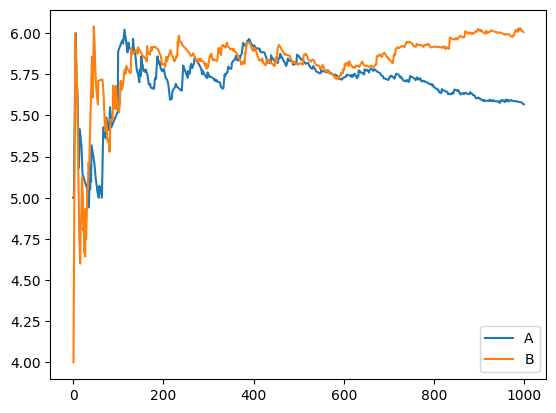

In [15]:
plt.plot(A.expanding().mean(), label='A')
plt.plot(B.expanding().mean(), label='B')
plt.legend()
plt.show()

## Задание 3.
**Дизайн эксперимента**
1) Откройте файл с данными `dataset_for_design`
2) Рассчитайте количество наблюдений, которое необходимо набрать, чтобы у этой метрики увидеть ее увеличение на 5%
3) Проверьте свой ответ с помощью метода Монте-Карло. Покажите, что мощность теста действительно совпадает с заявленной



In [16]:
data2 = pd.read_csv('/dataset_for_design-483a61b8-5e74-4478-95ff-5668535ef5b2.csv', index_col=0)
data2.head()

,user_id,total_orders
0,1,5.481016
1,2,3.514178
2,3,6.091976
3,4,11.242615
4,5,3.286040


In [17]:
from scipy.stats import norm

mu = data2["total_orders"].mean()
delta = 0.05 * mu # 5%
z_alpha = norm.ppf(1 - 0.05/2)
z_beta = norm.ppf(0.8)
n_size = (z_alpha + z_beta)**2 * 2 * data2["total_orders"].std(ddof=1)**2 / (delta**2)
n_size = int(np.ceil(n_size))
n_size


4292

In [19]:
success = 0
for i in range(2000):
  A = data2["total_orders"].sample(n_size, replace=True).values
  B = data2["total_orders"].sample(n_size, replace=True).values * 1.05

  _, p_val = ttest_ind(A, B, equal_var=False)
  if p_val < 0.05: success += 1
power_mc = success / 2000
power_mc

0.766